<a href="https://colab.research.google.com/github/codestashes/tflearn/blob/main/PlantClassificationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project #:8
## Name: Plant Classification
### Submitted by: Hari Ejilane
### On: 06/03/2022
---

### Problem definition
Recognizing/classifying plant seedlings using AI and Deep learning to shorten the time taken for manual classification.

---

### Objective
To build a CNN model to classify plant seedlings to their respective 12 categories.

---

In [ ]:
# Mount the Google drive to import the input dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import the necessary libraries
---

In [ ]:
# Basic python data processing modules
import numpy as np
import pandas as pd
import random
import warnings

# Image manipulation & visualization modules
import cv2
import matplotlib.pyplot as plt

# Data analysis & visualization modules
import seaborn as sns

# ML data processing modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

warnings.filterwarnings('ignore')

In [ ]:
# Load the images and labels into their respective dataframes
images = np.load('drive/MyDrive/PlantClassification/images.npy')
labels = pd.read_csv('drive/MyDrive/PlantClassification/Labels.csv')

In [ ]:
# Observe the size of the image and label datasets to conform consistency
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


#### Observation:
* There are **4750 images** in the input dataset.
* The image and labels **data sizes correspond**.

---

## Exploratory data analysis
---

In [ ]:
# Get a count of label categories to understand the dataset
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

In [ ]:
display(labels.Label.value_counts(normalize=True).to_frame().style.format('{:.2%}'))

,Label
Loose Silky-bent,13.77%
Common Chickweed,12.86%
Scentless Mayweed,10.86%
Small-flowered Cranesbill,10.44%
Fat Hen,10.00%
Charlock,8.21%
Sugar beet,8.11%
Cleavers,6.04%
Black-grass,5.54%
Shepherds Purse,4.86%


#### Observation:
* The data has a **definite class imbalance** and we need to ensure it is weighted properly before we perform any model training/testing.
* There is a **high representation** for classes like Loose Silky-bent and Common Chickweed whereas classes like Maize, Common wheat and Shepherds Purse have a **very low counts**.

---

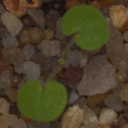

In [ ]:
# Let's observe a random image from the dataset for propriety.
from google.colab.patches import cv2_imshow
cv2_imshow(images[5])

In [ ]:
# Convert the RGB channels to reverse-RGB to work with the OpenCV module
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

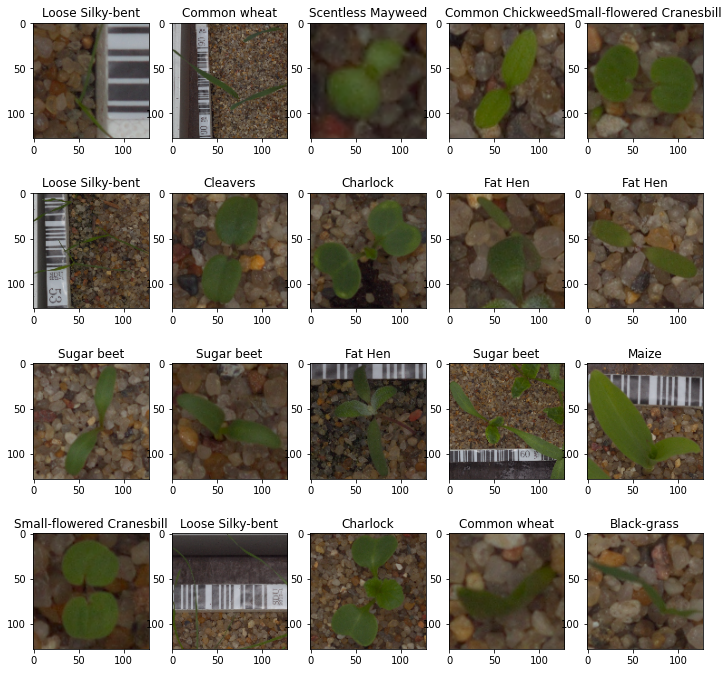

In [ ]:
# Before Preprocessing - plot random images from each class and print their corresponding labels
def show_images():
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 4                                                                        # Defining number of rows=3
  cols = 5                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(12, 12))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

show_images()

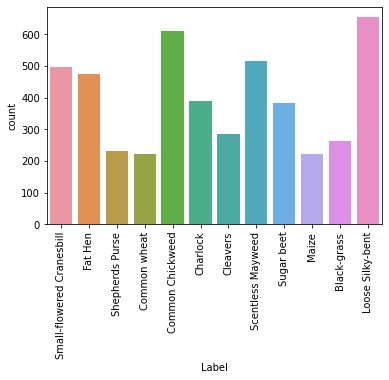

In [ ]:
# View the input data categories through a countplot
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical');

#### Observation:
* As observed during data loading, there is **class imbalance** in the images from the input dataset.
* Some **weighting mechanism** should be considered before using the images for any model training/testing process.

---

## Data preprocessing
---

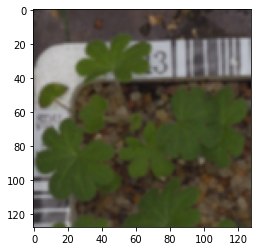

In [ ]:
# Let's apply Gaussian blurring technique to remove unwanted noise
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))

plt.imshow(images_gb[3])

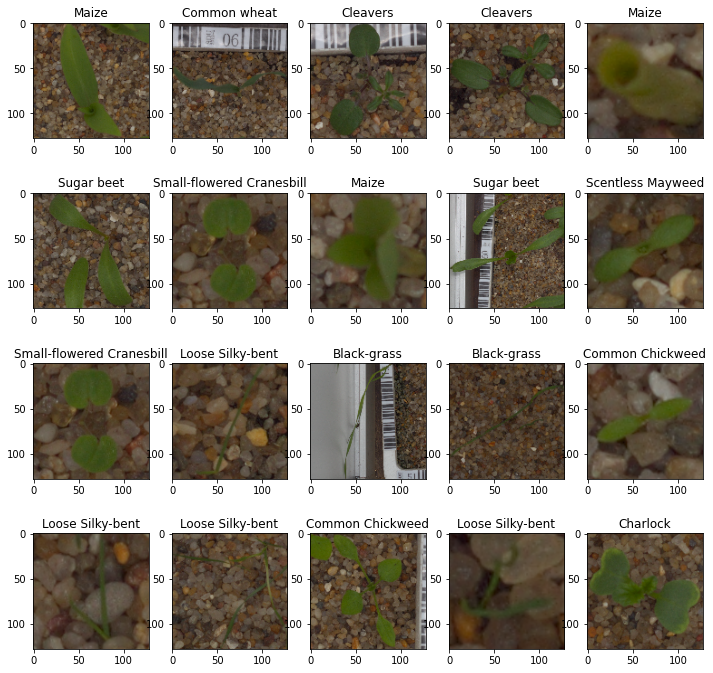

In [ ]:
# After Preprocessing - plot random images from each class and print their corresponding labels
show_images()

#### Observation:
* After preprocessing the only noticeable change in the pictures is that they are **blurred now**.

---

In [ ]:
# Let's now split the data into train, validation and test datasets.
# Also we will stratify the data on the labels array to make sure there is the 
# same representation of classes in the training, test & validation datasets.
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_gb),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

#### Observation:
* We see that there is almost the **same representation of each class** across the 3 datasets.

---

In [ ]:
# Let's use the Label binarizer from Sklearn library to encode the labels
# before training the model.
lblBinEnc = LabelBinarizer()
y_train_encoded = lblBinEnc.fit_transform(y_train)
y_val_encoded=lblBinEnc.transform(y_val)
y_test_encoded=lblBinEnc.transform(y_test)

In [ ]:
# Next let's standardize all the input images to have values between 0-1.
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [ ]:
print("Training dataset shapes >>> ", X_train.shape,y_train.shape)
print("Validation dataset shapes >>> ", X_val.shape,y_val.shape)
print("Testing dataset shapes >>> ", X_test.shape,y_test.shape)

Training dataset shapes >>>  (3847, 128, 128, 3) (3847, 1)
Validation dataset shapes >>>  (428, 128, 128, 3) (428, 1)
Testing dataset shapes >>>  (475, 128, 128, 3) (475, 1)


#### Observation:
* The shape of the input data after preprocessing is compatible to the Keras model building algorithm and **no further reshaping is necessary**.

---

In [ ]:
# Ensure the Keras runtime is reset before the model build process.
def reset_runtime():
  backend.clear_session()
  np.random.seed(1)
  random.seed(1)
  tf.random.set_seed(1)

reset_runtime()

## Model building
---

### Model A:
* A **simple CNN** model

In [ ]:
# Model init
modelA = Sequential()

# First Convolution layer
# 64 filters with kernel size 3x3
# with 'same' padding to ensure output size is same as input
# for image dimension of 128x128
modelA.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))

# Max pool to reduce output size of 1st Convolution layer
modelA.add(MaxPooling2D((2, 2), padding = 'same'))

# Second Convolution layer
# 32 filters with kernel size 3x3
# Activation function as ReLu
# with 'same' padding to ensure output size is same as input
modelA.add(Conv2D(32, (3, 3), activation='relu', padding="same"))

# Max pool to reduce output size of 2nd Convolution layer
modelA.add(MaxPooling2D((2, 2), padding = 'same'))

# Flatten the output from feature extraction to aid creating dense layers
modelA.add(Flatten())

# Only fully connected dense layer with 16 neurons
# Activation function as ReLu
modelA.add(Dense(16, activation='relu'))

# modelA.add(Dropout(0.3))

# Output layer
# with 12 neurons for 12 class categories
# Activation function as SoftMax for this multi-class classification problem
modelA.add(Dense(12, activation='softmax'))

# Using an Adam optimizer
opt=Adam()

# Begin model compilation
modelA.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Build a model summary
modelA.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 16)                5

In [ ]:
mdlA_hist = modelA.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

121/121 - 101s - loss: 1.6383 - accuracy: 0.4455 - val_loss: 1.5764 - val_accuracy: 0.5000 - 101s/epoch - 831ms/step
Epoch 4/30
121/121 - 102s - loss: 1.3282 - accuracy: 0.5537 - val_loss: 1.3637 - val_accuracy: 0.5654 - 102s/epoch - 839ms/step
Epoch 5/30


KeyboardInterrupt: ignored

In [ ]:
mdlA_acc = modelA.evaluate(X_test_normalized, y_test_encoded, verbose=2)

In [ ]:
mdlA_y_pred=modelA.predict(X_test_normalized)
mdlA_y_pred

In [ ]:
mdlA_y_pred_arg=np.argmax(mdlA_y_pred, axis=1)
mdlA_y_test_arg=np.argmax(y_test_encoded, axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
mdlA_cm = tf.math.confusion_matrix(mdlA_y_test_arg, mdlA_y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    mdlA_cm,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
pd.DataFrame(classification_report(mdlA_y_pred_arg, mdlA_y_test_arg, output_dict=True)).T

In [ ]:
# Let's plot the metric observations on a graph
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(mdlA_hist.history['accuracy'])
plt.plot(mdlA_hist.history['val_accuracy'])
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observation:
* The epoch-accuracy curve shows there is **definite overfitting** in the model.
* Let's try to build an improved CNN model to handle this overfitting.

---

### Model B:
* Model to include **data augmentation** using a Image data generator.
* Batch normalization in feature extraction layers and Dropout in dense layers to to **avoid overfitting**.
* Uses **SGD** as the optimizer.

In [ ]:
# Clear the backend session to reset the runtime environment
reset_runtime()

In [ ]:
# Let's now build a Image data generator to introduce data augmentation
# before building the model
train_datagen = ImageDataGenerator(
                              rotation_range=20, 
                              fill_mode='nearest'
                              )

In [ ]:
# Model init
modelB = Sequential()

# First Convolution layer
# 64 filters with kernel size 3x3
# with 'same' padding to ensure output size is same as input
# for image dimension of 128x128
modelB.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
# Max pool to reduce output size of 1st Convolution layer
modelB.add(MaxPooling2D((2, 2), padding = 'same'))
# Introducing a Batch normalization layer to handle overfitting from layer 1
modelB.add(BatchNormalization())

# Second Convolution layer
# 32 filters with kernel size 3x3
# Activation function as ReLu
# with 'same' padding to ensure output size is same as input
modelB.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
# Max pool to reduce output size of 2nd Convolution layer
modelB.add(MaxPooling2D((2, 2), padding = 'same'))
# Introducing a Batch normalization layer to handle overfitting from layer 2
modelB.add(BatchNormalization())

# Third Convolution layer
# 32 filters with kernel size 3x3
# Activation function as ReLu
# with 'same' padding to ensure output size is same as input
modelB.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
# Max pool to reduce output size of 3rd Convolution layer
modelB.add(MaxPooling2D((2, 2), padding = 'same'))
# Introducing a Batch normalization layer to handle overfitting from layer 3
modelB.add(BatchNormalization())

# Fourth Convolution layer
# 32 filters with kernel size 3x3
# Activation function as ReLu
# with 'same' padding to ensure output size is same as input
modelB.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
# Max pool to reduce output size of 4th Convolution layer
modelB.add(MaxPooling2D((2, 2), padding = 'same'))
# Introducing a Batch normalization layer to handle overfitting from layer 4
modelB.add(BatchNormalization())

# Flatten the output from feature extraction to aid creating dense layers
modelB.add(Flatten())

# Only fully connected dense layer with 16 neurons
# Activation function as ReLu
modelB.add(Dense(16, activation='relu'))
# Introducing a Dropout layer to handle overfitting from the dense layer
modelB.add(Dropout(0.3))

# Output layer
# with 12 neurons for 12 class categories
# Activation function as SoftMax for this multi-class classification problem
modelB.add(Dense(12, activation='softmax'))

# Let's explore more by using an SGD Optimizer
opt = SGD(learning_rate=0.001, momentum=0.9)

# Begin model compilation
modelB.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Build a model summary
modelB.summary()

In [ ]:
batch_size = 16
mdlB_hist = modelB.fit(
            train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=1,
                                       shuffle=False),
            epochs=200,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=batch_size,
            verbose=2
)

In [ ]:
mdlB_acc = modelB.evaluate(X_test_normalized, y_test_encoded, verbose=2)

In [ ]:
mdlB_y_pred=modelB.predict(X_test_normalized)
mdlB_y_pred

In [ ]:
mdlB_y_pred_arg=np.argmax(mdlB_y_pred, axis=1)
mdlB_y_test_arg=np.argmax(y_test_encoded, axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
mdlB_cm = tf.math.confusion_matrix(mdlB_y_test_arg, mdlB_y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    mdlB_cm,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
pd.DataFrame(classification_report(mdlB_y_pred_arg, mdlB_y_test_arg, output_dict=True)).T

In [ ]:
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(mdlB_hist.history['accuracy'])
plt.plot(mdlB_hist.history['val_accuracy'])
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#### Observation:
* The model **performs better** than the simple CNN (Model A) model.
* However it **takes quite a long time** to train the model for 200 epochs.
* Let's try to build a CNN model over **transfer learning** to improve the training time.

---

In [ ]:
## Model 3 - Transfer learn from VGG16

* Build a CNN **from the VGG16 model using Transfer learning**
* We will use the **same hyper parameters** and dense layers setup from Model B.

In [ ]:
# Clear the backend session to reset the runtime environment
reset_runtime()

In [ ]:
# Import the VGG16 model without the dense layers
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (128, 128, 3))
vgg_model.summary()

In [ ]:
# Set the inherited VGG16 layers to be untrainable
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
# Model init
modelC = Sequential()

# Adding the convolutional part of the VGG16 model from above
modelC.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
modelC.add(Flatten())

# Only fully connected dense layer with 16 neurons
# Activation function as ReLu
modelC.add(Dense(16, activation='relu'))
# Introducing a Dropout layer to handle overfitting from the dense layer
modelC.add(Dropout(0.3))

# Output layer
# with 12 neurons for 12 class categories
# Activation function as SoftMax for this multi-class classification problem
modelC.add(Dense(12, activation='softmax'))

# Let's explore more by using an SGD Optimizer
opt = SGD(learning_rate=0.001, momentum=0.9)

# Begin model compilation
modelC.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Build a model summary
modelC.summary()

In [ ]:
epochs = 100
batch_size = 16

# Fit the transfer learned new model
mdlC_hist = modelC.fit(train_datagen.flow(X_train_normalized, y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=1,
                                       shuffle=False),
                    epochs=epochs,
                    validation_data=(X_val_normalized, y_val_encoded),
                    verbose=1)

In [ ]:
mdlC_acc = modelC.evaluate(X_test_normalized, y_test_encoded, verbose=2)

In [ ]:
mdlC_y_pred = modelC.predict(X_test_normalized)
mdlC_y_pred

In [ ]:
mdlC_y_pred_arg=np.argmax(y_pred,axis=1)
mdlC_y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
mdlC_cm = tf.math.confusion_matrix(mdlC_y_pred_arg,mdlC_y_test_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    mdlC_cm,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(mdlC_hist.history['accuracy'])
plt.plot(mdlC_hist.history['val_accuracy'])
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()